In [2]:
from matplotlib import pyplot as plt
import numpy as np
import scipy.io

# Load dataset of our own handwritten letters

Char datset shape:  (240, 28, 28)


Text(0.5, 1.0, 'Sample 212')

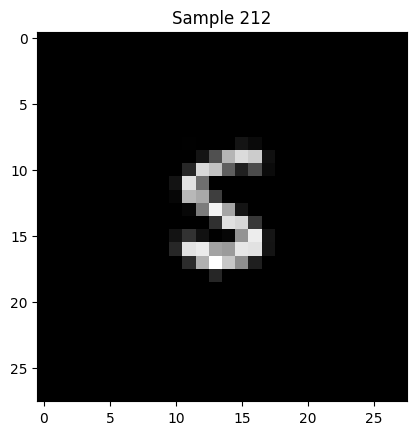

In [3]:
data = np.load('data/training/chars.npy')
# Normalize data
data = data/255

print("Char datset shape: ", data.shape)
random_sample = np.random.randint(0, len(data))
char = data[random_sample,:,:]
plt.imshow(char, cmap='gray')
plt.title('Sample ' + str(random_sample))

# Load EMNIST dataset

In [3]:
emnist = scipy.io.loadmat('data/training/emnist-letters.mat')
data = emnist['dataset']

X_train = data['train'][0,0]['images'][0,0]
y_train = data['train'][0,0]['labels'][0,0]
X_test = data['test'][0,0]['images'][0,0]
y_test = data['test'][0,0]['labels'][0,0]


## Create validation set
val_start = X_train.shape[0] - X_test.shape[0]
X_val = X_train[val_start:X_train.shape[0],:]
y_val = y_train[val_start:X_train.shape[0]]
X_train = X_train[0:val_start,:]
y_train = y_train[0:val_start]

print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", X_test.shape)
print("y test shape: ", y_test.shape)

print("X validation shape: ", X_val.shape)
print("y validation shape: ", y_val.shape)

X train shape:  (104000, 784)
y train shape:  (104000, 1)
X test shape:  (20800, 784)
y test shape:  (20800, 1)
X validation shape:  (20800, 784)
y validation shape:  (20800, 1)


(104000, 28, 28)

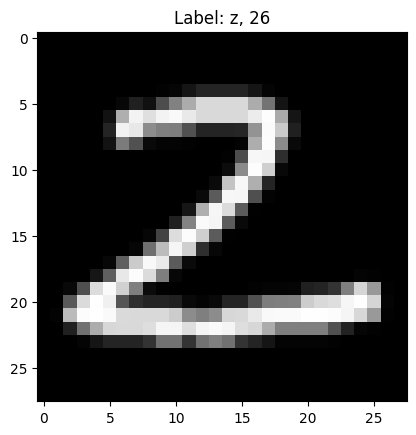

In [4]:
X_train = X_train.reshape((X_train.shape[0], 28, 28), order='F')

random_sample = np.random.randint(0, len(X_train))
char = X_train[random_sample,:,:]
label_i = y_train[random_sample,0]
# Translate labels to letter
letters = 'abcdefghijklmnopqrstuvwxyz'
label = letters[label_i-1]

plt.imshow(char, cmap='gray')
plt.title(f'Label: {label}, {label_i}')

X_train.shape

In [16]:
mappings = y_train[:,0]
mappings

array([23,  7, 16, ..., 21, 23, 25], dtype=uint8)